In [76]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [2]:
sql_15 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as yr_tt,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as weekday

    FROM bluetooth.aggr_15min bt
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
    WHERE hol.dt is NULL

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin),
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END)

SELECT bt.tt, 
	yr.yr_tt, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name,
	yr.weekday as workingday
FROM bluetooth.aggr_15min bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id 
		AND EXTRACT(year FROM bt.datetime_bin) = yr.year 
		AND bt.datetime_bin::time = yr.time
		AND CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END = yr.weekday)
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE left(aa.report_name, 4) = 'DT-0'
    AND hol.dt is NULL
'''

observations_15 = pandasql.read_sql(sql_15, con)

In [3]:
start = pd.Timestamp('2017-10-04 00:00:00')
end = pd.Timestamp('2017-10-05 00:00:00')
colors = ['#0f6006', '#3b86f7']

#(startobservations_30['report_name'].unique() <= observations.datetime_bin) & (observations.datetime_bin <= end)

#observations = observations.sort_values(['datetime_bin'])


In [5]:
r_name = 'DT-0019. Queen-EB_Roncesvalles-to-Dufferin'

In [6]:
def plot_base(observations):
    
    segments = {'Week' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Work')].sort_values(['datetime_bin']),
                'Weekend' : observations[(observations['report_name'] == r_name) & 
                            (observations['workingday'] == 'Weekend')].sort_values(['datetime_bin'])}
        
        
    fig, work = plt.subplots(1, 1, figsize = (16,16))
    
    weekend = work.twinx()
    weekend = work.twiny()
    days = [work, weekend]
    
    for i, (color, WD) in enumerate(zip(colors, ['Weekend', 'Week'])):
  #      handles.append(mpl.patches.Patch(color = color, label = WD))
        
   # weekday = []

        days[i].plot_date(x = segments[WD].datetime_bin.dt.time,
                             y = segments[WD].yr_tt,
                             xdate = True,
                             fmt = '-o',
                             c = color)
    #weekday.append([])
    #for j, WD in enumerate(['F', 'Sa', 'Su']):
     #   weekday[i].append(analysis[i].twinx())
      #  weekday[i][j].plot_date(x = segments[a_id][WD].datetime_bin,
       #                          y = segments[a_id][WD].yr_tt,
        #                         xdate = True,
         #                        fmt = '-o',
          #                       c = colors[j])
            
    days[1].get_xaxis().set_visible(False)
    days[1].get_yaxis().set_visible(False)
    plt.title('Baseline for ' + r_name + ' by Day')
   # analysis[i].set_xlim(pd.Timestamp(2017, 10, 26, 0, 0, 0), pd.Timestamp(2017, 10, 30, 0, 0))
    days[1].xaxis.set_label_text('Time')
    days[1].yaxis.set_label_text('Travel Time')
    plt.gcf().autofmt_xdate()
    plt.show()

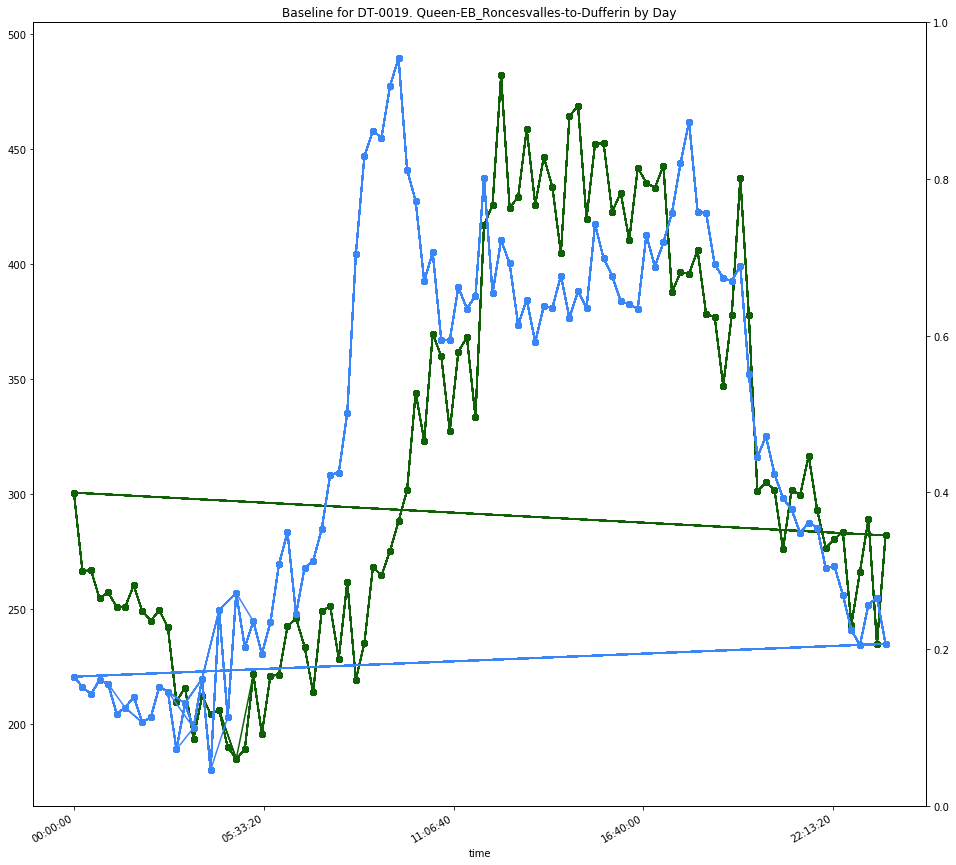

In [7]:
plot_base(observations_15)

In [8]:
sql_30 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as yr_tt,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as weekday

    FROM dt_30min_agg bt
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
    WHERE hol.dt is NULL

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin),
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END)

SELECT bt.travel_time, 
	yr.yr_tt, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name,
	yr.weekday as workingday
FROM dt_30min_agg bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id 
		AND EXTRACT(year FROM bt.datetime_bin) = yr.year 
		AND bt.datetime_bin::time = yr.time
		AND CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END = yr.weekday)
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
'''
observations_30 = pandasql.read_sql(sql_30, con)

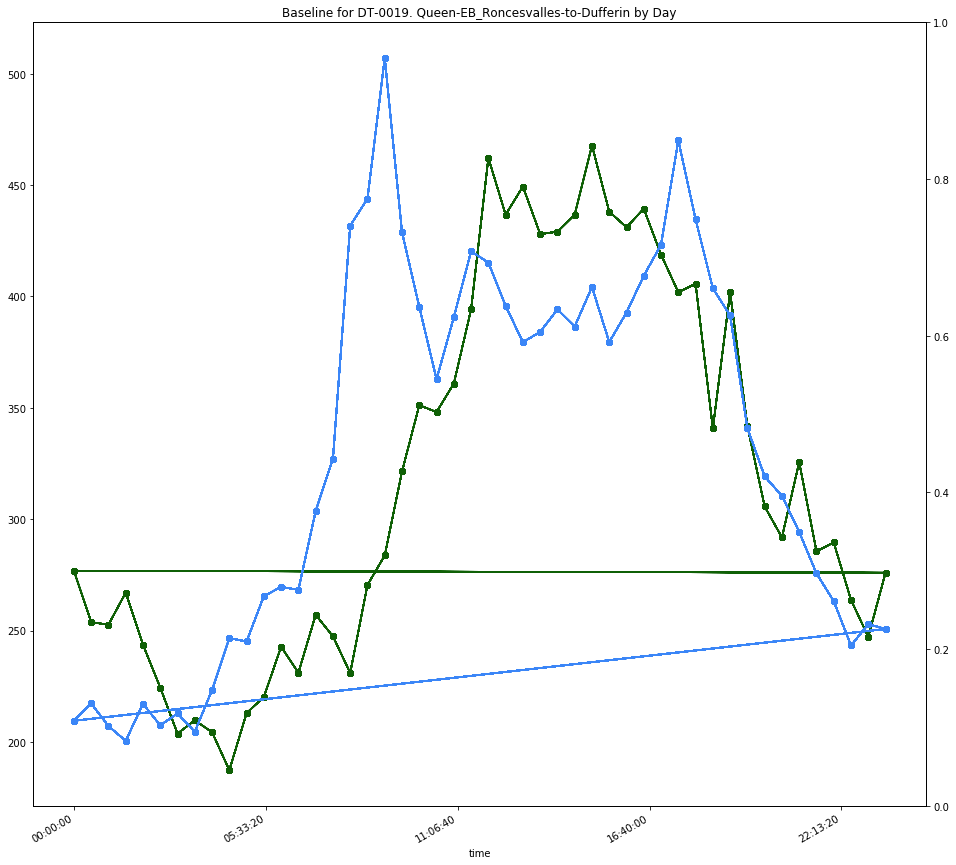

In [9]:
plot_base(observations_30)

In [10]:
def WOY(x, W):
    return x.weekofyear == W

In [11]:
weeks = {W : observations_30[(observations_30['report_name'] == r_name) & 
             observations_30['datetime_bin'].apply(WOY, args = (W,))]
        for W in observations_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}

In [12]:
temp = {}
for week, df in weeks.items():
    if not df.empty:
        temp[week] = weeks[week]
weeks = temp

In [131]:
fig, ax = plt.subplots(len(weeks.keys()), 1, sharex = False, figsize = (16, 16))
plt.suptitle('Travel times by week for ' + r_name)
for i, week in enumerate(weeks):
    ax[i].plot_date(x = weeks[week].datetime_bin,
                    y = weeks[week].travel_time)
    
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = range(0,6), interval=1))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
    ax[i].xaxis.set_minor_locator(mdates.HourLocator(interval=4))
    ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    
    ax[i].set_title(str(week))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Travel Time')
    ax[i].legend()
    
fig.tight_layout()

#st.set_y(0.95)
fig.subplots_adjust(top=0.95)
  #  print(week)
   # print(i)
    #make some graphs

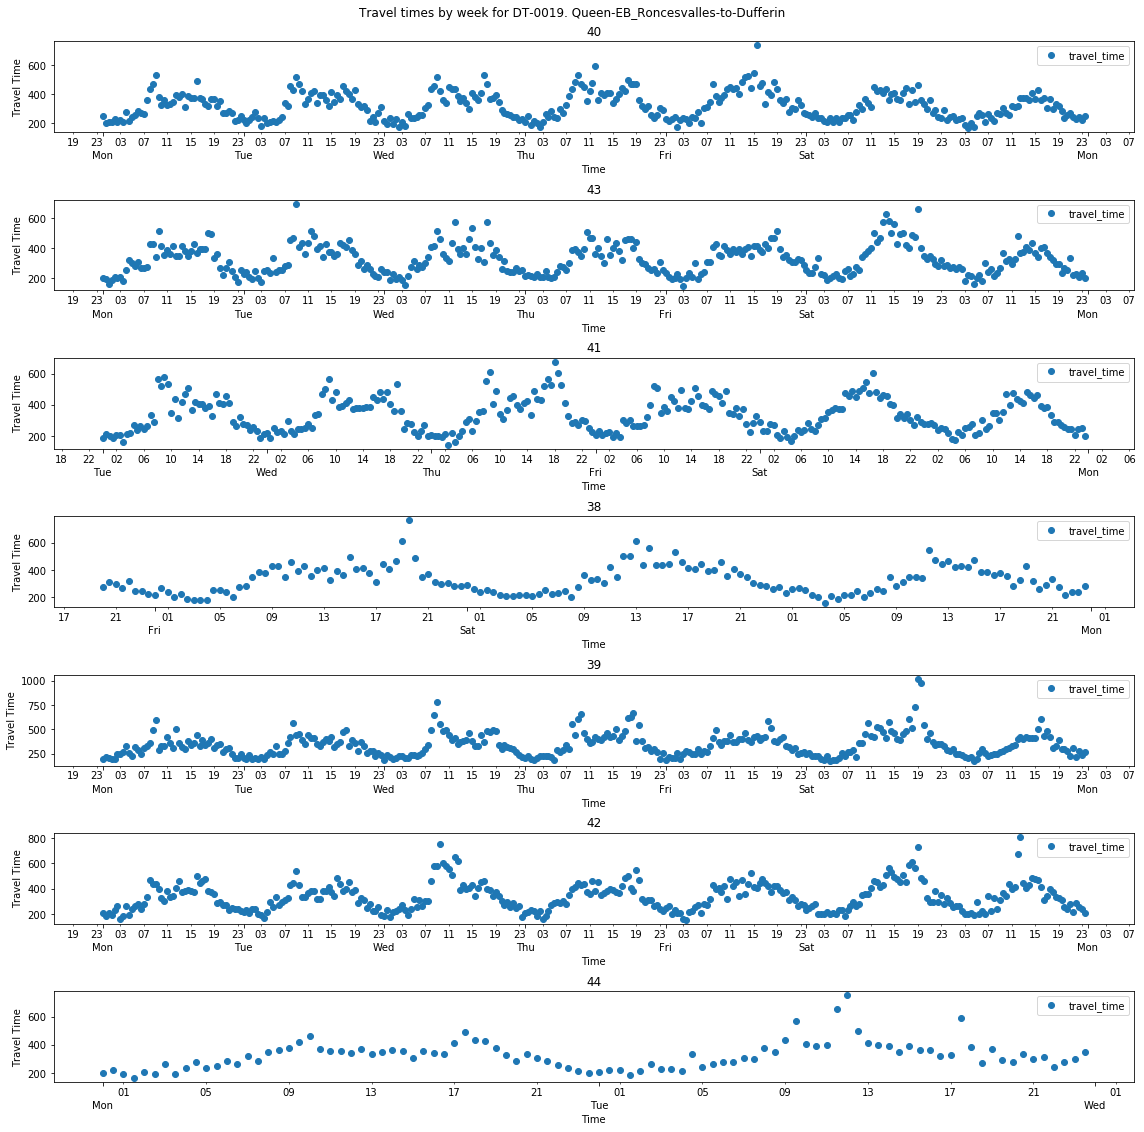

In [132]:
plt.show()

In [ ]:
weeks[week][weeks[week].report_name == r_name]

In [ ]:
colors = ['#004B85','#F2756D']

In [ ]:
def getfig(analysis_id, week):
    fig, BT = plt.subplots(figsize = (16,8))
    year = BT.twinx()
    year = BT.twiny()
    BT.plot_date(x = segments[analysis_id]['datetime_bin'],
                y = segments[analysis_id]['tt'],
                xdate = True,
                ydate = False,
                c = colors[0],
                fmt = '-o')
    year.plot_date(x = segments[analysis_id]['datetime_bin'],
                  y = segments[analysis_id]['yr_tt'],
                  xdate = True,
                  ydate = False,
                  c = colors[1],
                  fmt = '-o')
    
    BT.xaxis.set_label_text('Timestamp')
    BT.yaxis.set_label_text('Travel Time')
    
    #BT.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,6)))
    
    plt.title('Bluetooth VS Average Day on ' + str(analysis_id))
    
    BT.legend(loc = 'upper right')
    year.legend(loc= 'upper left')
    
    year.get_xaxis().set_visible(False)
    
    return fig

In [ ]:
for i, analysis_id in enumerate(segments):
    plt.show(getfig(analysis_id))
    if i > 5:
        break

In [ ]:
observations['report_name']